In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.colors
from scipy.ndimage.filters import gaussian_filter
from scipy.special import erf
from matplotlib.lines import Line2D
import h5py
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [114]:
samps_no_evol = np.load('./../../spin_alone/processed_emcee_samples_r00.npy')
samps = np.load('./../processed_emcee_samples_qDependence_r00.npy')
posteriors = np.load("./../../../input/sampleDict.pickle",allow_pickle=True)

samps_no_evol_no190412 = np.load('./../../spin_alone/processed_emcee_samples_no190412_r00.npy')
samps_no190412 = np.load('./../processed_emcee_samples_qDependence_no190412_r01.npy')
samps_w190814 = np.load('./../processed_emcee_samples_qDependence_w190814_r01.npy')
posteriors_no190412 = np.load("./../../../input/sampleDict.pickle",allow_pickle=True)
posteriors_no190412.pop('S190412m')
posteriors_w190814 = np.load("./../../../input/sampleDict_w190814.pickle",allow_pickle=True)

n_catalogs = 750

# Initial Scatter

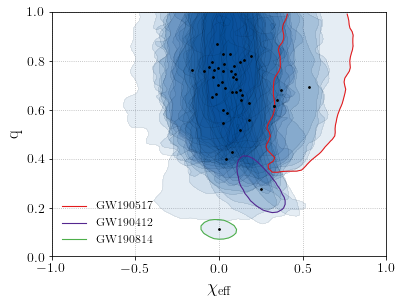

In [14]:
posteriors_w190814 = np.load("./../../../input/sampleDict_w190814.pickle",allow_pickle=True)

fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i,key in enumerate(list(posteriors_w190814.keys())):
    
    chis = posteriors_w190814[key]['Xeff']
    m1s = posteriors_w190814[key]['m1']
    m2s = posteriors_w190814[key]['m2']
    qs = m2s/m1s
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.2)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    if key=='S190517h':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif key=='S190412m':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    elif key=='S190814bv':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#4daf4a',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.1)
 

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1),
                Line2D([0], [0], color='#4daf4a', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412', 'GW190814'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

plt.savefig('./scatter.pdf',bbox_inches='tight')

(0.0, 1.0)

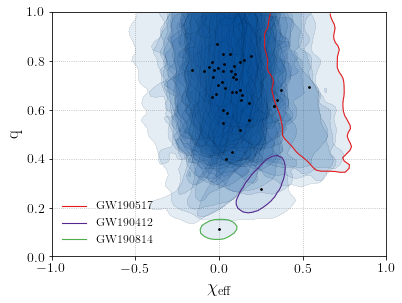

In [29]:
posteriors_w190814 = np.load("./../../../input/sampleDict_w190814.pickle",allow_pickle=True)

fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i,key in enumerate(list(posteriors_w190814.keys())):
    
    chis = posteriors_w190814[key]['Xeff']
    m1s = posteriors_w190814[key]['m1']
    m2s = posteriors_w190814[key]['m2']
    qs = m2s/m1s
    
    chis = 2.*np.median(chis) - chis
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.2)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    if key=='S190517h':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif key=='S190412m':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    elif key=='S190814bv':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#4daf4a',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.1)
 

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1),
                Line2D([0], [0], color='#4daf4a', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412', 'GW190814'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

# Reweighting and mock catalog generation

In [64]:
# Load mock detections
ref_m_min = 2.
ref_m_max = 100.
ref_a1 = -2.35
ref_a2 = 2.

mMin = 5.

mockDetections = h5py.File('/home/thomas.callister/RedshiftDistributions/spin-evolution/input/o3a_bbhpop_inj_info.hdf','r')
ifar_1 = mockDetections['injections']['ifar_gstlal'].value
ifar_2 = mockDetections['injections']['ifar_pycbc_bbh'].value
ifar_3 = mockDetections['injections']['ifar_pycbc_full'].value
detected = (ifar_1>1) + (ifar_2>1) + (ifar_3>1)
m1_det = mockDetections['injections']['mass1_source'].value[detected]
m2_det = mockDetections['injections']['mass2_source'].value[detected]
s1z_det = mockDetections['injections']['spin1z'].value[detected]
s2z_det = mockDetections['injections']['spin2z'].value[detected]
z_det = mockDetections['injections']['redshift'].value[detected]

mockDetectionsO1O2 = h5py.File('/home/thomas.callister/RedshiftDistributions/spin-evolution/input/injections_O1O2an_spin.h5','r')
m1_det = np.append(m1_det,mockDetectionsO1O2['mass1_source'])
m2_det = np.append(m2_det,mockDetectionsO1O2['mass2_source'])
s1z_det = np.append(s1z_det,mockDetectionsO1O2['spin1z'])
s2z_det = np.append(s2z_det,mockDetectionsO1O2['spin2z'])
z_det = np.append(z_det,mockDetectionsO1O2['redshift'])

# Derived quantities
q_det = m2_det/m1_det
X_det = (m1_det*s1z_det + m2_det*s2z_det)/(m1_det+m2_det)

ref_p_z = np.power(1.+z_det,2.-1.)
ref_p_m1 = np.power(m1_det,ref_a1)
ref_p_m2 = (1.+ref_a2)*np.power(m2_det,ref_a2)/(m1_det**(1.+ref_a2) - ref_m_min**(1.+ref_a2))

ref_p_xeff = np.zeros(X_det.size)
for i in range(ref_p_xeff.size):

    X = X_det[i]
    q = q_det[i]
    
    if X<-(1.-q)/(1.+q):
        ref_p_xeff[i] = (1./(2.*q))*(1.+q)*(1.+X)*(1.+q)/2.
        
    elif X>(1.-q)/(1.+q):
        ref_p_xeff[i] = (1./(2.*q))*(1.+q)*(1.-X)*(1.+q)/2.
        
    else:
        ref_p_xeff[i] = (1.+q)/2.

pop_reweight = 1./(ref_p_xeff*ref_p_m1*ref_p_m2*ref_p_z)
pop_reweight[m1_det<mMin] = 0.
pop_reweight[m2_det<mMin] = 0.

<ipython-input-64-d73ef177b37d>:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_1 = mockDetections['injections']['ifar_gstlal'].value
<ipython-input-64-d73ef177b37d>:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_2 = mockDetections['injections']['ifar_pycbc_bbh'].value
<ipython-input-64-d73ef177b37d>:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_3 = mockDetections['injections']['ifar_pycbc_full'].value
<ipython-input-64-d73ef177b37d>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  m1_det = mockDetections['injections']['mass1_source'].value[detected]
<ipython-input-64-d73ef177b37d>:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  m2_det = mockDetections['injections']['mass2_source'].value[detected]
<ipython-input-64-d73ef177b37d>:16: H5pyDeprecationWarning: datase

In [65]:
def calculate_Gaussian(x, mu, sigma2, low, high):
    norm = np.sqrt(sigma2*np.pi/2)*(-erf((low-mu)/np.sqrt(2*sigma2)) + erf((high-mu)/np.sqrt(2*sigma2)))
    if norm==0:
        return -np.inf*(x.shape)
    y = (1.0/norm)*np.exp((-1.0*(x-mu)**2)/(2.*sigma2))
    y[x<low] = 0.
    y[x>high] = 0.
    return y

mock_q_noEvol = np.zeros((len(posteriors),n_catalogs))
mock_x_noEvol = np.zeros((len(posteriors),n_catalogs))

resampled_q_noEvol = np.zeros((len(posteriors),n_catalogs))
resampled_x_noEvol = np.zeros((len(posteriors),n_catalogs))

mu_chi = np.zeros(n_catalogs)
logsig_chi = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_no_evol.shape[0]))
    
    mMin = 5.
    lmbda1 = samps_no_evol[samp,0]
    lmbda2 = samps_no_evol[samp,1]
    m0 = samps_no_evol[samp,2]
    bq = samps_no_evol[samp,3]
    kappa = samps_no_evol[samp,4]
    mu0 = samps_no_evol[samp,5]
    logsig0 = samps_no_evol[samp,6]
    
    mu_chi[i] = mu0
    logsig_chi[i] = logsig0
    
    mock_p_m1 = np.ones(m1_det.size)
    low_ms = m1_det<m0
    high_ms = m1_det>=m0
    p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
    mock_p_m1[low_ms] = p_m1_norm*np.power(m1_det[low_ms]/m0,lmbda1)
    mock_p_m1[high_ms] = p_m1_norm*np.power(m1_det[high_ms]/m0,lmbda2)   
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    mock_p_chi = calculate_Gaussian(X_det, mu0, 10.**(2.*logsig0),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors),p=p_det,replace=True)
    mock_q_noEvol[:,i] = q_det[detected_injections]
    mock_x_noEvol[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors):

        chis = posteriors[key]['Xeff']
        Xeff_prior = posteriors[key]['Xeff_priors']
        m1s = posteriors[key]['m1']
        m2s = posteriors[key]['m2']
        zs = posteriors[key]['z']
        weights = posteriors[key]['weights']
        qs = m2s/m1s

        p_Chi = calculate_Gaussian(chis, mu0, 10.**(2.*logsig0),-1.,1.)

        # p(m1)
        p_m1 = np.ones(m1s.size)
        low_ms = m1s<m0
        high_ms = m1s>=m0
        p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
        p_m1[low_ms] = p_m1_norm*np.power(m1s[low_ms]/m0,lmbda1)
        p_m1[high_ms] = p_m1_norm*np.power(m1s[high_ms]/m0,lmbda2)
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_noEvol[ii,i] = qs[chosenInd]
        resampled_x_noEvol[ii,i] = chis[chosenInd]

In [5]:
def calculate_Gaussian(x, mu, sigma2, low, high):
    norm = np.sqrt(sigma2*np.pi/2)*(-erf((low-mu)/np.sqrt(2*sigma2)) + erf((high-mu)/np.sqrt(2*sigma2)))
    y = (1.0/norm)*np.exp((-1.0*(x-mu)**2)/(2.*sigma2))
    y[x<low] = 0.
    y[x>high] = 0.
    return y

In [6]:

mock_q = np.zeros((len(posteriors),n_catalogs))
mock_x = np.zeros((len(posteriors),n_catalogs))

resampled_q = np.zeros((len(posteriors),n_catalogs))
resampled_x = np.zeros((len(posteriors),n_catalogs))

mu_chi_evol = np.zeros(n_catalogs)
logsig_chi_evol = np.zeros(n_catalogs)
alpha_evol = np.zeros(n_catalogs)
beta_evol = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps.shape[0]))
    
    mMin = 5.
    lmbda1 = samps[samp,0]
    lmbda2 = samps[samp,1]
    m0 = samps[samp,2]
    bq = samps[samp,3]
    kappa = samps[samp,4]
    mu0 = samps[samp,5]
    logsig0 = samps[samp,6]
    alpha = samps[samp,7]
    beta = samps[samp,8]
    
    mu_chi_evol[i] = mu0
    logsig_chi_evol[i] = logsig0    
    alpha_evol[i] = alpha
    beta_evol[i] = beta
    
    mock_p_m1 = np.ones(m1_det.size)
    low_ms = m1_det<m0
    high_ms = m1_det>=m0
    p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
    mock_p_m1[low_ms] = p_m1_norm*np.power(m1_det[low_ms]/m0,lmbda1)
    mock_p_m1[high_ms] = p_m1_norm*np.power(m1_det[high_ms]/m0,lmbda2)   
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    
    mu = mu0 + alpha*(q_det-0.5)
    logsig = logsig0 + beta*(q_det-0.5)
    mock_p_chi = calculate_Gaussian(X_det, mu, 10.**(2.*logsig),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors),p=p_det,replace=False)
    mock_q[:,i] = q_det[detected_injections]
    mock_x[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors):

        chis = posteriors[key]['Xeff']
        Xeff_prior = posteriors[key]['Xeff_priors']
        m1s = posteriors[key]['m1']
        m2s = posteriors[key]['m2']
        zs = posteriors[key]['z']
        weights = posteriors[key]['weights']
        qs = m2s/m1s
        
        mu = mu0 + alpha*(qs-0.5)
        logsig = logsig0 + beta*(qs-0.5)
        p_Chi = calculate_Gaussian(chis, mu, 10.**(2.*logsig),-1.,1.)

        # p(m1)
        p_m1 = np.ones(m1s.size)
        low_ms = m1s<m0
        high_ms = m1s>=m0
        p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
        p_m1[low_ms] = p_m1_norm*np.power(m1s[low_ms]/m0,lmbda1)
        p_m1[high_ms] = p_m1_norm*np.power(m1s[high_ms]/m0,lmbda2)
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q[ii,i] = qs[chosenInd]
        resampled_x[ii,i] = chis[chosenInd]

In [122]:
mock_q_noEvol_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))
mock_x_noEvol_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))

resampled_q_noEvol_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))
resampled_x_noEvol_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))

mu_chi_no190412 = np.zeros(n_catalogs)
logsig_chi_no190412 = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_no_evol_no190412.shape[0]))
    
    mMin = 5.
    lmbda1 = samps_no_evol_no190412[samp,0]
    lmbda2 = samps_no_evol_no190412[samp,1]
    m0 = samps_no_evol_no190412[samp,2]
    bq = samps_no_evol_no190412[samp,3]
    kappa = samps_no_evol_no190412[samp,4]
    mu0 = samps_no_evol_no190412[samp,5]
    logsig0 = samps_no_evol_no190412[samp,6]
    
    mu_chi_no190412[i] = mu0
    logsig_chi_no190412[i] = logsig0
    
    mock_p_m1 = np.ones(m1_det.size)
    low_ms = m1_det<m0
    high_ms = m1_det>=m0
    p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
    mock_p_m1[low_ms] = p_m1_norm*np.power(m1_det[low_ms]/m0,lmbda1)
    mock_p_m1[high_ms] = p_m1_norm*np.power(m1_det[high_ms]/m0,lmbda2)   
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    mock_p_chi = calculate_Gaussian(X_det, mu0, 10.**(2.*logsig0),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors_no190412),p=p_det,replace=True)
    mock_q_noEvol_no190412[:,i] = q_det[detected_injections]
    mock_x_noEvol_no190412[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors_no190412):

        chis = posteriors_no190412[key]['Xeff']
        Xeff_prior = posteriors_no190412[key]['Xeff_priors']
        m1s = posteriors_no190412[key]['m1']
        m2s = posteriors_no190412[key]['m2']
        zs = posteriors_no190412[key]['z']
        weights = posteriors_no190412[key]['weights']
        qs = m2s/m1s

        p_Chi = calculate_Gaussian(chis, mu0, 10.**(2.*logsig0),-1.,1.)

        # p(m1)
        p_m1 = np.ones(m1s.size)
        low_ms = m1s<m0
        high_ms = m1s>=m0
        p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
        p_m1[low_ms] = p_m1_norm*np.power(m1s[low_ms]/m0,lmbda1)
        p_m1[high_ms] = p_m1_norm*np.power(m1s[high_ms]/m0,lmbda2)
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_noEvol_no190412[ii,i] = qs[chosenInd]
        resampled_x_noEvol_no190412[ii,i] = chis[chosenInd]

In [131]:
mock_q_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))
mock_x_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))

resampled_q_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))
resampled_x_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))

mu_chi_evol_no190412 = np.zeros(n_catalogs)
logsig_chi_evol_no190412 = np.zeros(n_catalogs)
alpha_evol_no190412 = np.zeros(n_catalogs)
beta_evol_no190412 = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_no190412.shape[0]))
    
    mMin = 5.
    lmbda1 = samps_no190412[samp,0]
    lmbda2 = samps_no190412[samp,1]
    m0 = samps_no190412[samp,2]
    bq = samps_no190412[samp,3]
    kappa = samps_no190412[samp,4]
    mu0 = samps_no190412[samp,5]
    logsig0 = samps_no190412[samp,6]
    alpha = samps_no190412[samp,7]
    beta = samps_no190412[samp,8]
    
    mu_chi_evol_no190412[i] = mu0
    logsig_chi_evol_no190412[i] = logsig0    
    alpha_evol_no190412[i] = alpha
    beta_evol_no190412[i] = beta
    
    mock_p_m1 = np.ones(m1_det.size)
    low_ms = m1_det<m0
    high_ms = m1_det>=m0
    p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
    mock_p_m1[low_ms] = p_m1_norm*np.power(m1_det[low_ms]/m0,lmbda1)
    mock_p_m1[high_ms] = p_m1_norm*np.power(m1_det[high_ms]/m0,lmbda2)   
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    
    mu = mu0 + alpha*(q_det-0.5)
    logsig = logsig0 + beta*(q_det-0.5)
    mock_p_chi = calculate_Gaussian(X_det, mu, 10.**(2.*logsig),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors_no190412),p=p_det,replace=False)
    mock_q_no190412[:,i] = q_det[detected_injections]
    mock_x_no190412[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors_no190412):

        chis = posteriors_no190412[key]['Xeff']
        Xeff_prior = posteriors_no190412[key]['Xeff_priors']
        m1s = posteriors_no190412[key]['m1']
        m2s = posteriors_no190412[key]['m2']
        zs = posteriors_no190412[key]['z']
        weights = posteriors_no190412[key]['weights']
        qs = m2s/m1s
        
        mu = mu0 + alpha*(qs-0.5)
        logsig = logsig0 + beta*(qs-0.5)
        p_Chi = calculate_Gaussian(chis, mu, 10.**(2.*logsig),-1.,1.)

        # p(m1)
        p_m1 = np.ones(m1s.size)
        low_ms = m1s<m0
        high_ms = m1s>=m0
        p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
        p_m1[low_ms] = p_m1_norm*np.power(m1s[low_ms]/m0,lmbda1)
        p_m1[high_ms] = p_m1_norm*np.power(m1s[high_ms]/m0,lmbda2)
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_no190412[ii,i] = qs[chosenInd]
        resampled_x_no190412[ii,i] = chis[chosenInd]

In [9]:
mock_q_w190814 = np.zeros((len(posteriors_w190814),n_catalogs))
mock_x_w190814 = np.zeros((len(posteriors_w190814),n_catalogs))

resampled_q_w190814 = np.zeros((len(posteriors_w190814),n_catalogs))
resampled_x_w190814 = np.zeros((len(posteriors_w190814),n_catalogs))

mu_chi_evol_w190814 = np.zeros(n_catalogs)
logsig_chi_evol_w190814 = np.zeros(n_catalogs)
alpha_evol_w190814 = np.zeros(n_catalogs)
beta_evol_w190814 = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_w190814.shape[0]))
    
    mMin = 2.5
    lmbda1 = samps_w190814[samp,0]
    lmbda2 = samps_w190814[samp,1]
    m0 = samps_w190814[samp,2]
    bq = samps_w190814[samp,3]
    kappa = samps_w190814[samp,4]
    mu0 = samps_w190814[samp,5]
    logsig0 = samps_w190814[samp,6]
    alpha = samps_w190814[samp,7]
    beta = samps_w190814[samp,8]
    
    mu_chi_evol_w190814[i] = mu0
    logsig_chi_evol_w190814[i] = logsig0    
    alpha_evol_w190814[i] = alpha
    beta_evol_w190814[i] = beta
    
    mock_p_m1 = np.ones(m1_det.size)
    low_ms = m1_det<m0
    high_ms = m1_det>=m0
    p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
    mock_p_m1[low_ms] = p_m1_norm*np.power(m1_det[low_ms]/m0,lmbda1)
    mock_p_m1[high_ms] = p_m1_norm*np.power(m1_det[high_ms]/m0,lmbda2)   
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    
    mu = mu0 + alpha*(q_det-0.5)
    logsig = logsig0 + beta*(q_det-0.5)
    mock_p_chi = calculate_Gaussian(X_det, mu, 10.**(2.*logsig),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors_w190814),p=p_det,replace=False)
    mock_q_w190814[:,i] = q_det[detected_injections]
    mock_x_w190814[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors_w190814):

        chis = posteriors_w190814[key]['Xeff']
        Xeff_prior = posteriors_w190814[key]['Xeff_priors']
        m1s = posteriors_w190814[key]['m1']
        m2s = posteriors_w190814[key]['m2']
        zs = posteriors_w190814[key]['z']
        weights = posteriors_w190814[key]['weights']
        qs = m2s/m1s
        
        mu = mu0 + alpha*(qs-0.5)
        logsig = logsig0 + beta*(qs-0.5)
        p_Chi = calculate_Gaussian(chis, mu, 10.**(2.*logsig),-1.,1.)

        # p(m1)
        p_m1 = np.ones(m1s.size)
        low_ms = m1s<m0
        high_ms = m1s>=m0
        p_m1_norm = (1.+lmbda1)*(1.+lmbda2)/(m0*(lmbda2-lmbda1)-mMin*np.power(mMin/m0,lmbda1)*(1.+lmbda2))
        p_m1[low_ms] = p_m1_norm*np.power(m1s[low_ms]/m0,lmbda1)
        p_m1[high_ms] = p_m1_norm*np.power(m1s[high_ms]/m0,lmbda2)
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_w190814[ii,i] = qs[chosenInd]
        resampled_x_w190814[ii,i] = chis[chosenInd]

# Blob plot, reweighted to non-evolving population

(0.0, 1.0)

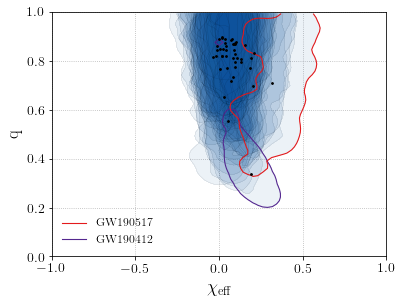

In [172]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q_noEvol.shape[0]):
    
    chis = resampled_x_noEvol[i,:]
    qs = resampled_q_noEvol[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    i190517=np.where(np.array(list(posteriors.keys()))=='S190517h')[0][0]
    i190412=np.where(np.array(list(posteriors.keys()))=='S190412m')[0][0]
    
    if i==i190517:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif i==i190412:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)


    ###elif key=='S190412m':
    ###    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    ###elif key=='S190814bv':
    ###    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#4daf4a',linewidths=1.1)
    ###else:
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

#plt.savefig('./reweighted_posterior_scatter_noEvolution.pdf',bbox_inches='tight')

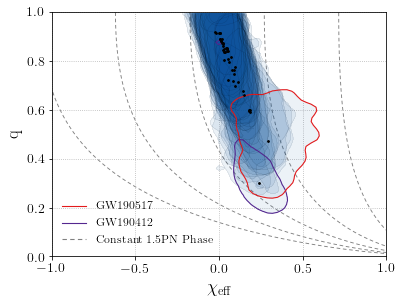

In [28]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q.shape[0]):
    
    chis = resampled_x[i,:]
    qs = resampled_q[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    i190517=np.where(np.array(list(posteriors.keys()))=='S190517h')[0][0]
    i190412=np.where(np.array(list(posteriors.keys()))=='S190412m')[0][0]
    
    if i==i190517:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif i==i190412:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 
# See Ng+ Eq. A2
for dphase in np.linspace(-4.5,-1.5,5):
    qs = np.linspace(0.01,1,100)
    etas = qs/(1.+qs)**2
    chi_effs = (dphase*etas**(3./5.) + 3.*np.pi/8.)*128./(113.-76.*etas)
    ax.plot(chi_effs,qs,color='grey',dashes=(4,3),zorder=-1,lw=0.9)

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1),
                Line2D([0], [0], color='grey', lw=1.1,dashes=(4,3))]
ax.legend(custom_lines, ['GW190517', 'GW190412','Constant 1.5PN Phase'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

plt.savefig('./reweighted_posterior_scatter_yesEvolution.pdf',bbox_inches='tight')

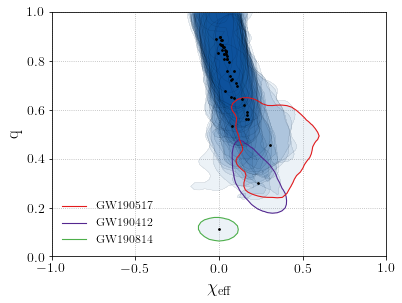

In [13]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q_w190814.shape[0]):
    
    chis = resampled_x_w190814[i,:]
    qs = resampled_q_w190814[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    i190517=np.where(np.array(list(posteriors_w190814.keys()))=='S190517h')[0][0]
    i190412=np.where(np.array(list(posteriors_w190814.keys()))=='S190412m')[0][0]
    i190814=np.where(np.array(list(posteriors_w190814.keys()))=='S190814bv')[0][0]
    
    if i==i190517:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif i==i190412:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    elif i==i190814:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#4daf4a',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)

    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1),
                Line2D([0], [0], color='#4daf4a', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412', 'GW190814'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)



ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

plt.savefig('./reweighted_posterior_scatter_yesEvolution_w190814.pdf',bbox_inches='tight')

# Residual Plots

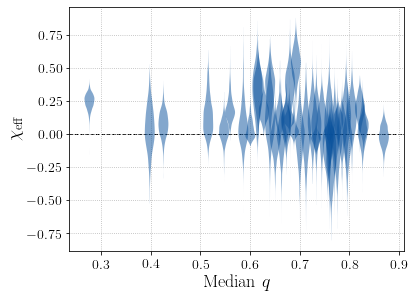

In [160]:
# Default posteriors
fig,ax = plt.subplots(figsize=(6,4.5))
    
median_qs = [np.median(posteriors[k]['m2']/posteriors[k]['m1']) for k in posteriors]
q_sorting = np.argsort(median_qs)

vs = ax.violinplot(np.array([posteriors[k]['Xeff'] for k in posteriors]).T,positions=median_qs,widths=0.02,showextrema=False)
for v in vs['bodies']:
    v.set_facecolor('#08519c')
    v.set_alpha(0.5)

ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel('Median $q$',fontsize=18)
ax.set_ylabel('$\chi_\mathrm{eff}$',fontsize=18)

plt.show()

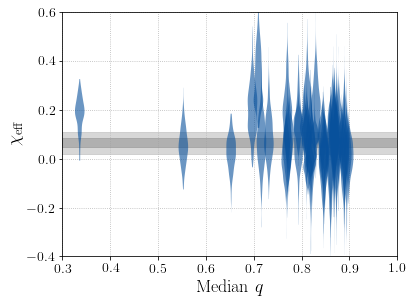

In [230]:
fig,ax = plt.subplots(figsize=(6,4.5))
    
median_qs = np.median(resampled_q_noEvol,axis=1)
q_sorting = np.argsort(median_qs)

mu_05,mu_25,mu_75,mu_95 = np.quantile(mu_chi,[0.05,0.25,0.75,0.95])
ax.fill_between([0,1],mu_05,mu_95,color='#bdbdbd',alpha=0.6)
ax.fill_between([0,1],mu_25,mu_75,color='#969696',alpha=0.6)

vs = ax.violinplot((resampled_x_noEvol).T,positions=median_qs,widths=0.02,showextrema=False)
for v in vs['bodies']:
    v.set_facecolor('#08519c')
    v.set_alpha(0.6)

"""
ax.errorbar(median_qs,np.median(resampled_x_noEvol,axis=1),ls="none",marker='o',color="#08519c",
           yerr=[np.quantile(resampled_x_noEvol,0.95,axis=1)-np.median(resampled_x_noEvol,axis=1),
                 np.median(resampled_x_noEvol,axis=1)-np.quantile(resampled_x_noEvol,0.05,axis=1)])
"""      
#ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel('Median $q$',fontsize=18)
ax.set_ylabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_xlim(0.3,1.)
ax.set_ylim(-0.4,0.6)

plt.savefig('./default_population_residuals.pdf',bbox_inches='tight')

plt.show()

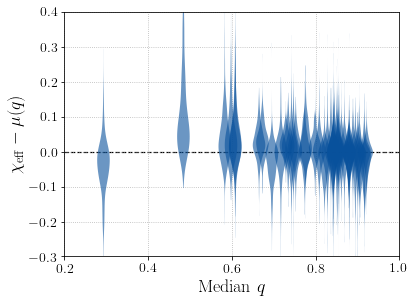

In [256]:
fig,ax = plt.subplots(figsize=(6,4.5))
    
median_qs = np.median(resampled_q,axis=1)
q_sorting = np.argsort(median_qs)
pop_means = mu_chi_evol + alpha_evol*(resampled_q-0.5)

vs = ax.violinplot((resampled_x-pop_means).T,positions=median_qs,widths=0.03,showextrema=False)
for v in vs['bodies']:
    v.set_facecolor('#08519c')
    v.set_alpha(0.6)

ax.axhline(y=0,ls='--',color='black',zorder=-1,lw=1.2)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel('Median $q$',fontsize=18)
ax.set_ylabel('$\chi_\mathrm{eff} - \mu(q)$',fontsize=18)
ax.set_xlim(0.2,1.)
ax.set_ylim(-0.3,0.4)

#plt.savefig('./default_population_residuals.pdf',bbox_inches='tight')

plt.show()

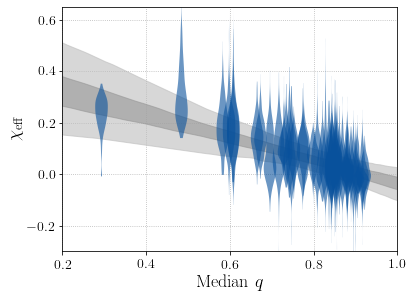

In [276]:
fig,ax = plt.subplots(figsize=(6,4.5))
    
median_qs = np.median(resampled_q,axis=1)
q_sorting = np.argsort(median_qs)

qs = np.linspace(0,1,100)
pop_means = np.array([mu_chi_evol[i] + alpha_evol[i]*(qs-0.5) for i in range(500)])
ax.fill_between(qs,np.quantile(pop_means,0.05,axis=0),np.quantile(pop_means,0.95,axis=0),color='#bdbdbd',alpha=0.6)
ax.fill_between(qs,np.quantile(pop_means,0.25,axis=0),np.quantile(pop_means,0.75,axis=0),color='#969696',alpha=0.6)


vs = ax.violinplot((resampled_x).T,positions=median_qs,widths=0.03,showextrema=False)
for v in vs['bodies']:
    v.set_facecolor('#08519c')
    v.set_alpha(0.6)

#ax.axhline(y=0,ls='--',color='black',zorder=-1,lw=1.2)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel('Median $q$',fontsize=18)
ax.set_ylabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_xlim(0.2,1.)
ax.set_ylim(-0.3,0.65)

plt.savefig('./evolving_population_residuals.pdf',bbox_inches='tight')

plt.show()

# Predictive check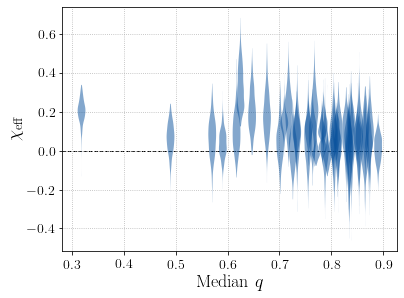

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


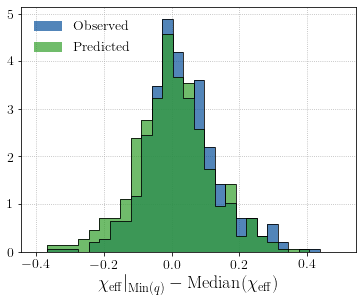

In [10]:
diffs_minQ_medQ_chi = np.zeros(n_catalogs)
mock_diffs_minQ_medQ_chi = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    ind_minq = np.argmin(resampled_q_noEvol[:,i])
    mock_ind_minq = np.argmin(mock_q_noEvol[:,i])
    
    diffs_minQ_medQ_chi[i] = resampled_x_noEvol[ind_minq,i] - np.median(resampled_x_noEvol[:,i])
    mock_diffs_minQ_medQ_chi[i] = mock_x_noEvol[mock_ind_minq,i] - np.median(mock_x_noEvol[:,i])
    
fig,ax = plt.subplots(figsize=(6,4.5))

ax.hist(diffs_minQ_medQ_chi,density=True,bins=np.linspace(-0.4,0.5,30),label='Observed',color='#08519c',alpha=0.7)
ax.hist(diffs_minQ_medQ_chi,histtype='step',density=True,bins=np.linspace(-0.4,0.5,30),color='black',lw=0.8)

ax.hist(mock_diffs_minQ_medQ_chi,density=True,bins=np.linspace(-0.4,0.5,30),alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_diffs_minQ_medQ_chi,histtype='step',density=True,bins=np.linspace(-0.4,0.5,30),color='black',lw=0.8)

ax.set_xlabel(r'$\chi_\mathrm{eff}|_{\mathrm{Min}(q)} - \mathrm{Median}(\chi_\mathrm{eff})$',fontsize=18)
ax.legend(loc='upper left',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
#plt.savefig('ppc_noEvolution.pdf',bbox_inches='tight')
plt.show()

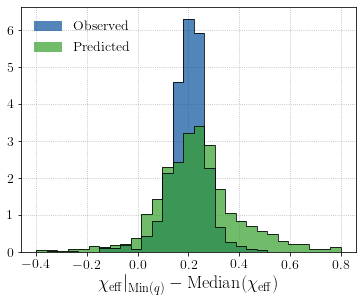

In [15]:
diffs_minQ_medQ_chi = np.zeros(n_catalogs)
mock_diffs_minQ_medQ_chi = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    ind_minq = np.argmin(resampled_q[:,i])
    mock_ind_minq = np.argmin(mock_q[:,i])
    
    diffs_minQ_medQ_chi[i] = resampled_x[ind_minq,i] - np.median(resampled_x[:,i])
    mock_diffs_minQ_medQ_chi[i] = mock_x[mock_ind_minq,i] - np.median(mock_x[:,i])
    
fig,ax = plt.subplots(figsize=(6,4.5))

ax.hist(diffs_minQ_medQ_chi,density=True,bins=np.linspace(-0.4,0.8,30),label='Observed',color='#08519c',alpha=0.7)
ax.hist(diffs_minQ_medQ_chi,histtype='step',density=True,bins=np.linspace(-0.4,0.8,30),color='black',lw=0.8)

ax.hist(mock_diffs_minQ_medQ_chi,density=True,bins=np.linspace(-0.4,0.8,30),alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_diffs_minQ_medQ_chi,histtype='step',density=True,bins=np.linspace(-0.4,0.8,30),color='black',lw=0.8)
ax.set_xlabel(r'$\chi_\mathrm{eff}|_{\mathrm{Min}(q)} - \mathrm{Median}(\chi_\mathrm{eff})$',fontsize=18)
ax.legend(loc='upper left',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
#plt.savefig('ppc_yesEvolution.pdf',bbox_inches='tight')
plt.show()

# PPC Testing

In [112]:
obs_q_max = np.zeros(n_catalogs)
obs_q_min = np.zeros(n_catalogs)
mock_q_max = np.zeros(n_catalogs)
mock_q_min = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    mus = mu_chi[i]
    logsigs = logsig_chi[i]
    
    ind = 1
    obs_q_max[i] = obs_qs[np.argsort(obs_xs)[-ind-1]]
    obs_q_min[i] = obs_qs[np.argsort(obs_xs)[ind]]
    
    mock_q_max[i] = mock_qs[np.argsort(mock_xs)[-ind-1]]
    mock_q_min[i] = mock_qs[np.argsort(mock_xs)[ind]]

In [113]:
np.mean(mock_q_max-mock_q_min)

-0.00033556825373608256

In [114]:
print(np.mean(obs_q_max-obs_q_min),np.std(obs_q_max-obs_q_min)/np.sqrt(n_catalogs))

-0.06741387045051263 0.008917560943958827


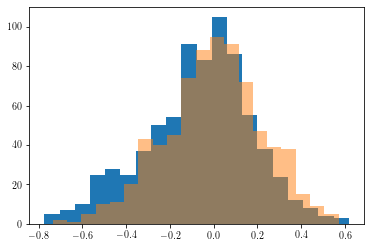

0.56

In [115]:
plt.hist(obs_q_max-obs_q_min,bins=20)
plt.hist(mock_q_max-mock_q_min,bins=20,alpha=0.5)
plt.show()

np.where(obs_q_max-obs_q_min<mock_q_max-mock_q_min)[0].size/n_catalogs

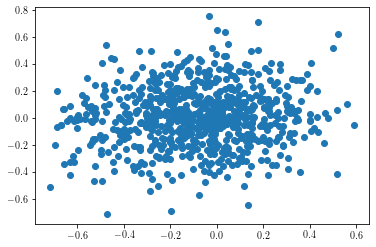

In [103]:
plt.scatter(obs_q_max-obs_q_min,mock_q_max-mock_q_min)

In [123]:
obs_slope = np.zeros(n_catalogs)
mock_slope = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    mus = mu_chi[i]
    logsigs = logsig_chi[i]
    
    obs_slope[i] = (obs_qs[np.argmax(obs_xs)] - obs_qs[np.argmin(obs_xs)])/(np.max(obs_xs)-np.min(obs_xs))
    mock_slope[i] = (mock_qs[np.argmax(mock_xs)] - mock_qs[np.argmin(mock_xs)])/(np.max(mock_xs)-np.min(mock_xs))

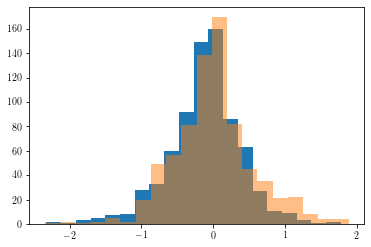

0.5693333333333334


In [124]:
plt.hist(obs_slope,bins=20)
plt.hist(mock_slope,bins=20,alpha=0.5)
plt.show()
print(np.where(obs_slope<mock_slope)[0].size/n_catalogs)

In [117]:
resampled_x_noEvol.shape

(44, 750)

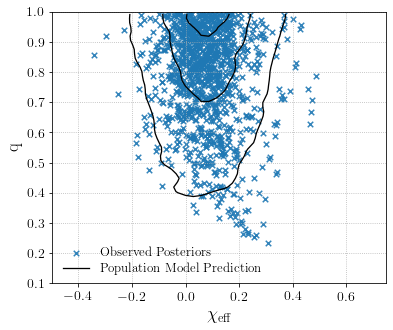

In [277]:
fig = plt.figure(figsize=(6,5))

cats = np.random.choice(np.arange(resampled_x_noEvol.shape[1]),size=25,replace=False)
ax = fig.add_subplot(111)

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]
    
heights,edgex,edgey = np.histogram2d(mock_x_noEvol.reshape(-1),mock_q_noEvol.reshape(-1),bins=(chi_grid,q_grid))
heights = gaussian_filter(heights,1.2)
heights /= np.sum(heights)*dchi*dq
heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
num_grid_pts = np.where(cdf>0.9)[0][0]
h90 = np.interp(0.9,cdf,heights_large_to_small)
h50 = np.interp(0.5,cdf,heights_large_to_small)
h10 = np.interp(0.1,cdf,heights_large_to_small)
ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,h50,h10,np.inf),colors='black',linewidths=1.3,zorder=1)


ax.scatter(resampled_x_noEvol[:,cats].reshape(-1),resampled_q_noEvol[:,cats].reshape(-1),marker='x',color='#1f78b4',s=30,zorder=-2,alpha=0.9,label='Observed Posteriors')
#ax.scatter(mock_x_noEvol.reshape(-1),mock_q_noEvol.reshape(-1),label='Predicted',marker='.',alpha=1)
#ax.hexbin(mock_x_noEvol.reshape(-1),mock_q_noEvol.reshape(-1),cmap='Blues',zorder=-1,gridsize=50)
ax.set_xlim(-0.5,0.75)
ax.set_ylim(0.1,1)
ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)

custom_lines = [Line2D([0], [0], color='black', lw=1.3)]
leg2 = plt.legend(custom_lines, ['Population Model Prediction'],loc=(0.02,0.01),fontsize=13,frameon=False,labelspacing=0.3)

ax.legend(frameon=False,loc=(0.02,0.07),fontsize=13)
ax.add_artist(leg2)

plt.savefig('./obs_scatter.pdf',bbox_inches='tight')
plt.show()

In [224]:
pearsonr(mock_q_noEvol.reshape(-1),mock_x_noEvol.reshape(-1))

(0.002055213360516168, 0.7088996514972625)

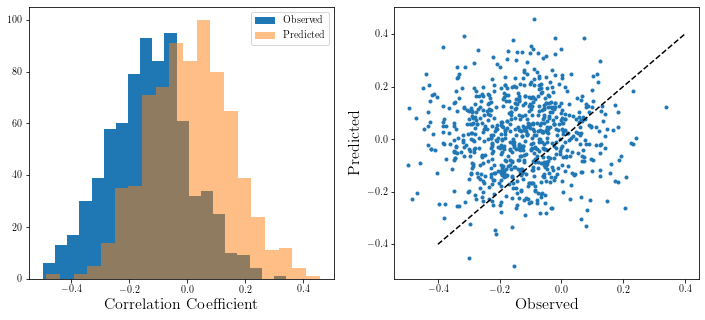

In [14]:
obs_corr = np.zeros(n_catalogs)
mock_corr = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    r,p = pearsonr(obs_qs,obs_xs)
    obs_corr[i] = r
    
    r,p = pearsonr(mock_qs,mock_xs)
    mock_corr[i] = r
    
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
ax.hist(obs_corr,label='Observed',bins=20)
ax.hist(mock_corr,alpha=0.5,label='Predicted',bins=20)
plt.legend()
ax.set_xlabel("Correlation Coefficient",fontsize=16)

ax = fig.add_subplot(122)
ax.scatter(obs_corr,mock_corr,marker='.')
ax.plot([-0.4,0.4],[-0.4,0.4],color='black',ls='--')
ax.set_xlabel("Observed",fontsize=16)
ax.set_ylabel("Predicted",fontsize=16)

plt.show()

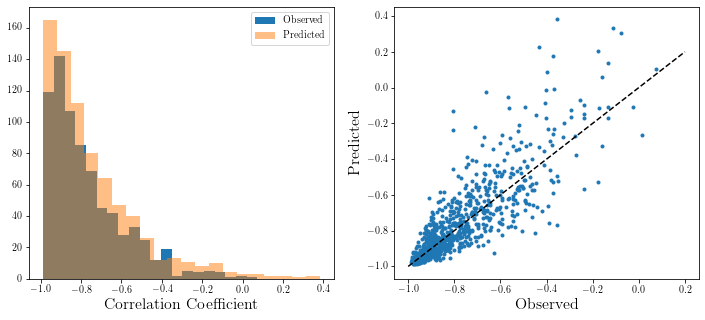

In [13]:
obs_corr = np.zeros(n_catalogs)
mock_corr = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q[:,i]
    mock_qs = mock_q[:,i]
    obs_xs = resampled_x[:,i]
    mock_xs = mock_x[:,i]
    
    r,p = pearsonr(obs_qs,obs_xs)
    obs_corr[i] = r
    
    r,p = pearsonr(mock_qs,mock_xs)
    mock_corr[i] = r
    
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
ax.hist(obs_corr,label='Observed',bins=20)
ax.hist(mock_corr,alpha=0.5,label='Predicted',bins=20)
plt.legend()
ax.set_xlabel("Correlation Coefficient",fontsize=16)

ax = fig.add_subplot(122)
ax.scatter(obs_corr,mock_corr,marker='.')
ax.plot([-1,0.2],[-1,0.2],color='black',ls='--')
ax.set_xlabel("Observed",fontsize=16)
ax.set_ylabel("Predicted",fontsize=16)

plt.show()

In [218]:
obs_slope = np.zeros(n_catalogs)
mock_slope = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    X = np.transpose([np.ones(obs_qs.size),obs_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(obs_xs)
    obs_slope[i] = m
    
    X = np.transpose([np.ones(mock_qs.size),mock_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(mock_xs)
    mock_slope[i] = m

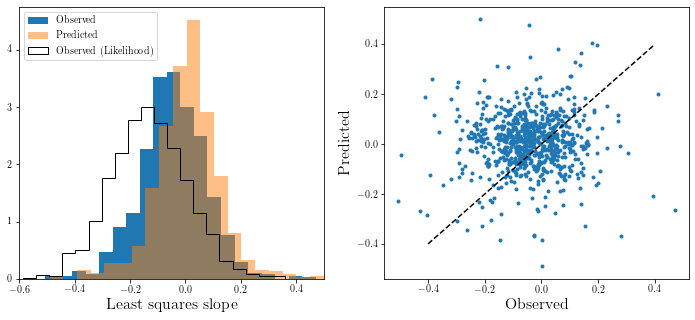

In [215]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
ax.hist(obs_slope,label='Observed',bins=20,density=True)
ax.hist(mock_slope,alpha=0.5,label='Predicted',bins=20,density=True)
ax.hist(slopes,density=True,histtype='step',color='black',bins=20,label='Observed (Likelihood)')
plt.legend(loc='upper left')
ax.set_xlim(-0.6,0.5)
ax.set_xlabel("Least squares slope",fontsize=16)

ax = fig.add_subplot(122)
ax.scatter(obs_slope,mock_slope,marker='.')
ax.plot([-0.4,0.4],[-0.4,0.4],color='black',ls='--')
ax.set_xlabel("Observed",fontsize=16)
ax.set_ylabel("Predicted",fontsize=16)

plt.show()

In [156]:
obs_slope = np.zeros(n_catalogs)
mock_slope = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q[:,i]
    mock_qs = mock_q[:,i]
    obs_xs = resampled_x[:,i]
    mock_xs = mock_x[:,i]
    
    X = np.transpose([np.ones(obs_qs.size),obs_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(obs_xs)
    obs_slope[i] = m
    
    X = np.transpose([np.ones(mock_qs.size),mock_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(mock_xs)
    mock_slope[i] = m

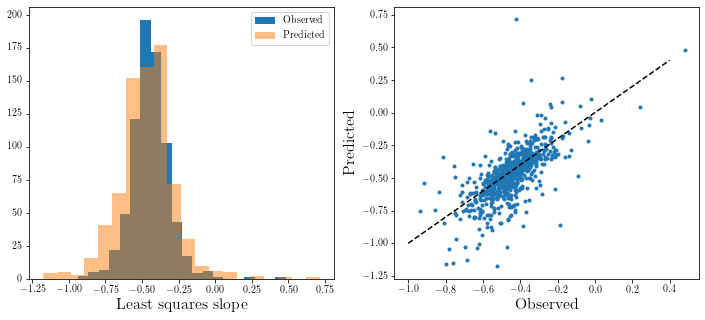

In [158]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
ax.hist(obs_slope,label='Observed',bins=20)
ax.hist(mock_slope,alpha=0.5,label='Predicted',bins=20)
plt.legend()
ax.set_xlabel("Least squares slope",fontsize=16)

ax = fig.add_subplot(122)
ax.scatter(obs_slope,mock_slope,marker='.')
ax.plot([-1,0.4],[-1,0.4],color='black',ls='--')
ax.set_xlabel("Observed",fontsize=16)
ax.set_ylabel("Predicted",fontsize=16)

plt.show()

In [147]:
np.where(obs_slope<mock_slope)[0].size/n_catalogs

0.42933333333333334

In [83]:
def alignedPrior(q,xs,aMax):

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(xs,-1)

    # Set up various piecewise cases
    pdfs = np.zeros(xs.size)
    caseA = (xs>aMax*(1.-q)/(1.+q))*(xs<=aMax)
    caseB = (xs<-aMax*(1.-q)/(1.+q))*(xs>=-aMax)
    caseC = (xs>=-aMax*(1.-q)/(1.+q))*(xs<=aMax*(1.-q)/(1.+q))

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]
    x_C = xs[caseC]

    q_A = q[caseA]
    q_B = q[caseB]
    q_C = q[caseC]

    pdfs[caseA] = (1.+q_A)**2.*(aMax-x_A)/(4.*q_A*aMax**2)
    pdfs[caseB] = (1.+q_B)**2.*(aMax+x_B)/(4.*q_B*aMax**2)
    pdfs[caseC] = (1.+q_C)/(2.*aMax)

    return pdfs

In [89]:
def calculate_Gaussian(x, mu, sigma2, low, high):
    norm = np.sqrt(sigma2*np.pi/2)*(-erf((low-mu)/np.sqrt(2*sigma2)) + erf((high-mu)/np.sqrt(2*sigma2)))
    if norm==0:
        return -np.inf*(x.shape)
    y = (1.0/norm)*np.exp((-1.0*(x-mu)**2)/(2.*sigma2))
    y[x<low] = 0.
    y[x>high] = 0.
    return y

like_q = np.zeros((len(posteriors),1000))
like_x = np.zeros((len(posteriors),1000))

for ii,key in enumerate(posteriors):

    chis = posteriors[key]['Xeff']
    Xeff_prior = posteriors[key]['Xeff_priors']
    m1s = posteriors[key]['m1']
    m2s = posteriors[key]['m2']
    zs = posteriors[key]['z']
    weights = posteriors[key]['weights']
    qs = m2s/m1s

    old_m1_prior = np.ones(m1s.size)
    old_m2_prior = np.ones(m1s.size)
    old_pz_prior = (1.+zs)**(2.7-1.)

    # Draw probs
    #probs = weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
    probs = np.ones(weights.size)

    if np.any(probs!=probs):
        print(np.where(probs!=probs))
        print(probs)
    probs[probs<0] = 0.
    probs /= np.sum(probs)
    print(1./np.max(probs))
    chosenInd = np.random.choice(np.arange(m1s.size),p=probs,size=1000,replace=True)
    like_q[ii,:] = qs[chosenInd]
    like_x[ii,:] = chis[chosenInd]

3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0


(0.0, 1.0)

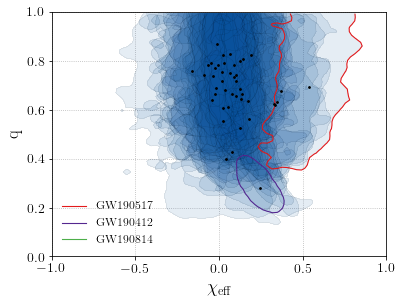

In [90]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i,key in enumerate(list(posteriors.keys())):
    
    chis = like_x[i,:]
    qs = like_q[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.2)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    if key=='S190517h':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif key=='S190412m':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    elif key=='S190814bv':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#4daf4a',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.1)
 

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1),
                Line2D([0], [0], color='#4daf4a', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412', 'GW190814'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

In [91]:
slopes = np.array([])
for i in range(1000):
    
    xs = np.array([])
    qs = np.array([])
    
    for ii in range(len(posteriors)):
        random_ind = np.random.choice(np.arange(1000))
        xs = np.append(xs,like_x[ii,random_ind])
        qs = np.append(qs,like_q[ii,random_ind])
        
    X = np.transpose([np.ones(qs.size),qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(xs)
    slopes = np.append(slopes,m)

(array([  4.,  23.,  72., 187., 273., 237., 136.,  52.,  12.,   4.]),
 array([-0.58594173, -0.49128942, -0.39663712, -0.30198481, -0.20733251,
        -0.11268021, -0.0180279 ,  0.0766244 ,  0.17127671,  0.26592901,
         0.36058131]),
 <BarContainer object of 10 artists>)

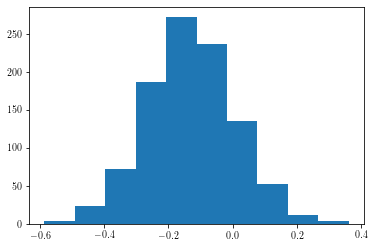

In [92]:
plt.hist(slopes)

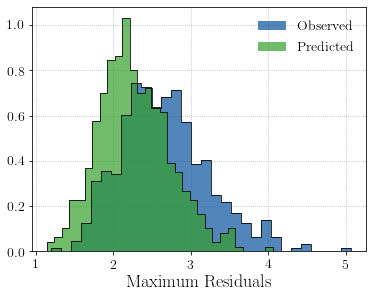

0.708


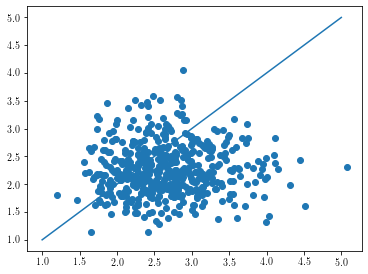

In [159]:
counts = np.zeros(n_catalogs)
mock_counts = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    qlow = 0.
    dq = 1.
    if np.any((obs_qs>qlow)*(obs_qs<qlow+dq)):
        counts[i] = (np.max(obs_xs[(obs_qs>qlow)*(obs_qs<qlow+dq)]) - mu_chi[i])/(10.**logsig_chi[i])
    if np.any((mock_qs>qlow)*(mock_qs<qlow+dq)):
        mock_counts[i] = (np.max(mock_xs[(mock_qs>qlow)*(mock_qs<qlow+dq)]) - mu_chi[i])/(10.**logsig_chi[i])
    
fig,ax = plt.subplots(figsize=(6,4.5))
ax.hist(counts[counts!=0],density=True,bins=30,label='Observed',color='#08519c',alpha=0.7)
ax.hist(counts[counts!=0],histtype='step',density=True,bins=30,color='black',lw=0.8)
ax.hist(mock_counts[mock_counts!=0],density=True,bins=30,alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_counts[mock_counts!=0],histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.set_xlabel(r'Maximum Residuals',fontsize=18)
ax.legend(loc='upper right',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
plt.savefig('ppc_residual_noEvolution.pdf',bbox_inches='tight')
plt.show()

print(np.where(counts>mock_counts)[0].size/counts.size)

fig,ax = plt.subplots(figsize=(6,4.5))
ax.scatter(counts[counts!=0],mock_counts[mock_counts!=0])
ax.plot([1,5],[1,5])
plt.show()

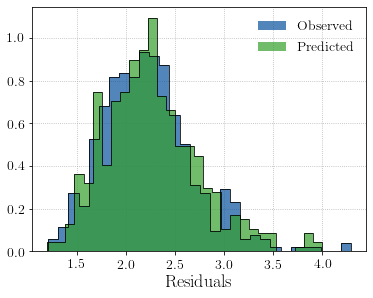

0.508


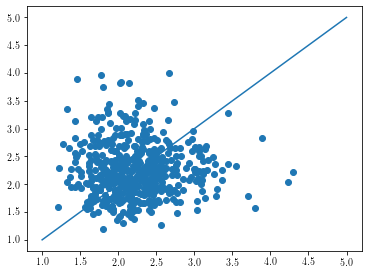

In [150]:
counts = np.zeros(n_catalogs)
mock_counts = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q[:,i]
    mock_qs = mock_q[:,i]
    obs_xs = resampled_x[:,i]
    mock_xs = mock_x[:,i]
    
    mus = mu_chi_evol[i] + alpha_evol[i]*(obs_qs - 0.5)
    logsigs = logsig_chi_evol[i] + beta_evol[i]*(obs_qs - 0.5)
    counts[i] = np.max((obs_xs - mus)/(10.**logsigs))
    
    mock_mus = mu_chi_evol[i] + alpha_evol[i]*(mock_qs - 0.5)
    mock_logsigs = logsig_chi_evol[i] + beta_evol[i]*(mock_qs - 0.5)
    mock_counts[i] = np.max((mock_xs - mock_mus)/(10.**mock_logsigs))
    
fig,ax = plt.subplots(figsize=(6,4.5))

ax.hist(counts,density=True,bins=30,label='Observed',color='#08519c',alpha=0.7)
ax.hist(counts,histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.hist(mock_counts,density=True,bins=30,alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_counts,histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.set_xlabel(r'Residuals',fontsize=18)
ax.legend(loc='upper right',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
plt.savefig('ppc_residual.pdf',bbox_inches='tight')
plt.show()

print(np.where(counts>mock_counts)[0].size/counts.size)

fig,ax = plt.subplots(figsize=(6,4.5))
ax.scatter(counts[counts!=0],mock_counts[mock_counts!=0])
ax.plot([1,5],[1,5])
plt.show()

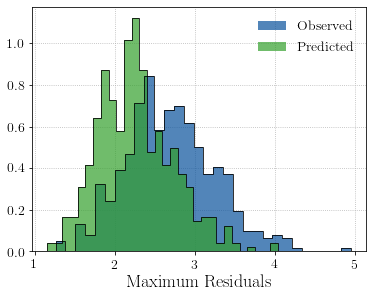

0.732


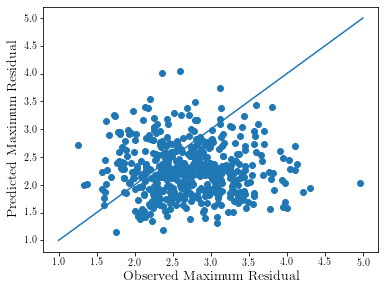

In [148]:
counts = np.zeros(n_catalogs)
mock_counts = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol_no190412[:,i]
    mock_qs = mock_q_noEvol_no190412[:,i]
    obs_xs = resampled_x_noEvol_no190412[:,i]
    mock_xs = mock_x_noEvol_no190412[:,i]
    
    qlow = 0.
    dq = 1.
    if np.any((obs_qs>qlow)*(obs_qs<qlow+dq)):
        counts[i] = (np.max(obs_xs[(obs_qs>qlow)*(obs_qs<qlow+dq)]) - mu_chi_no190412[i])/(10.**logsig_chi_no190412[i])
    if np.any((mock_qs>qlow)*(mock_qs<qlow+dq)):
        mock_counts[i] = (np.max(mock_xs[(mock_qs>qlow)*(mock_qs<qlow+dq)]) - mu_chi_no190412[i])/(10.**logsig_chi_no190412[i])
    
fig,ax = plt.subplots(figsize=(6,4.5))

ax.hist(counts[counts!=0],density=True,bins=30,label='Observed',color='#08519c',alpha=0.7)
ax.hist(counts[counts!=0],histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.hist(mock_counts[mock_counts!=0],density=True,bins=30,alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_counts[mock_counts!=0],histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.set_xlabel(r'Maximum Residuals',fontsize=18)
ax.legend(loc='upper right',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
plt.savefig('ppc_residual_noEvolution_no190412.pdf',bbox_inches='tight')
plt.show()

print(np.where(counts>mock_counts)[0].size/counts.size)

fig,ax = plt.subplots(figsize=(6,4.5))
ax.scatter(counts[counts!=0],mock_counts[mock_counts!=0])
ax.set_xlabel('Observed Maximum Residual',fontsize=14)
ax.set_ylabel('Predicted Maximum Residual',fontsize=14)
ax.plot([1,5],[1,5])
plt.show()

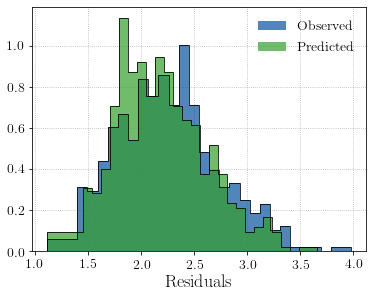

0.538


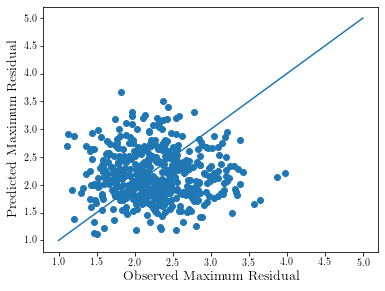

In [151]:
counts = np.zeros(n_catalogs)
mock_counts = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_no190412[:,i]
    mock_qs = mock_q_no190412[:,i]
    obs_xs = resampled_x_no190412[:,i]
    mock_xs = mock_x_no190412[:,i]
    
    mus = mu_chi_evol_no190412[i] + alpha_evol_no190412[i]*(obs_qs - 0.5)
    logsigs = logsig_chi_evol_no190412[i] + beta_evol_no190412[i]*(obs_qs - 0.5)
    counts[i] = np.max((obs_xs - mus)/(10.**logsigs))
    
    mock_mus = mu_chi_evol_no190412[i] + alpha_evol_no190412[i]*(mock_qs - 0.5)
    mock_logsigs = logsig_chi_evol_no190412[i] + beta_evol_no190412[i]*(mock_qs - 0.5)
    mock_counts[i] = np.max((mock_xs - mock_mus)/(10.**mock_logsigs))
    
fig,ax = plt.subplots(figsize=(6,4.5))

ax.hist(counts,density=True,bins=30,label='Observed',color='#08519c',alpha=0.7)
ax.hist(counts,histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.hist(mock_counts,density=True,bins=30,alpha=0.7,label='Predicted',color='#33a02c')
ax.hist(mock_counts,histtype='step',density=True,bins=30,color='black',lw=0.8)

ax.set_xlabel(r'Residuals',fontsize=18)
ax.legend(loc='upper right',fontsize=14,frameon=False)
ax.axhline(y=0,zorder=-1,color='black',ls='--',lw=1)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
plt.savefig('ppc_residual_no190412.pdf',bbox_inches='tight')
plt.show()

print(np.where(counts>mock_counts)[0].size/counts.size)

fig,ax = plt.subplots(figsize=(6,4.5))
ax.scatter(counts[counts!=0],mock_counts[mock_counts!=0])
ax.set_xlabel('Observed Maximum Residual',fontsize=14)
ax.set_ylabel('Predicted Maximum Residual',fontsize=14)
ax.plot([1,5],[1,5])
plt.show()

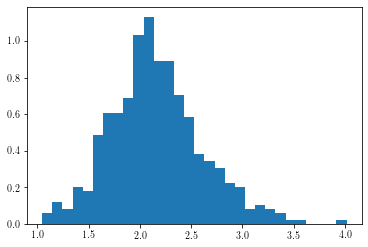

In [103]:
test = [np.max(np.random.normal(loc=0,scale=1,size=44)) for i in range(500)]
fig,ax = plt.subplots()
ax.hist(test,density=True,bins=30)
plt.show()

# Corner Plots

In [36]:
# Helper function to obtain 90% credible bounds from a list of samples
# Invoked by plot_corner to create labels on 1D posteriors
def getBounds(data):
    
    # Transform to a numpy arry
    data = np.array(data)

    # Get median, 5% and 95% quantiles
    med = np.median(data)
    upperLim = np.sort(data)[int(0.95*data.size)]
    lowerLim = np.sort(data)[int(0.05*data.size)]
 
    # Turn quantiles into upper and lower uncertainties
    upperError = upperLim-med
    lowerError = med-lowerLim
    
    return med,upperError,lowerError
    
def plot_corner(fig,plot_data,color,hist_alpha=0.7,bins=20,labelsize=14,kernel=2):
    
    # Input variable plot_data should be a dictionary whose keys are the individual variables to plot.
    # Each key should, in turn, link to another nested dictionary with the following keys:
    # - "data" : Actual data values
    # - "plot_bounds" : Tuple of min/max values to display on plot
    # - "label" : Latex string for figure labeling

    # Define a linear color map
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",color])
    
    # Loop across dimensions that we want to plot
    keys = list(plot_data)    
    ndim = len(keys)
    for i,key in enumerate(keys):
       
        # Plot the marginal 1D posterior (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
        ax.set_rasterization_zorder(1)
        
        ax.hist(plot_data[key]['data'],bins=np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],bins),\
               rasterized=True,color=color,alpha=hist_alpha,density=True,zorder=0)
        ax.hist(plot_data[key]['data'],bins=np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],bins),\
                histtype='step',color='black',density=True,zorder=2)
        ax.grid(True,dashes=(1,3))
        ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
        ax.set_title(r"${0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(*getBounds(plot_data[key]['data'])),fontsize=14)

        # Turn off tick labels if this isn't the first dimension
        if i!=0:
            ax.set_yticklabels([])

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(plot_data[key]['label'],fontsize=labelsize)
            
        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:
            
            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):
                
                # Make a 2D density plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))
                ax.set_rasterization_zorder(1)
                
                ax.hexbin(plot_data[key]['data'],plot_data[k]['data'],cmap=cmap,mincnt=1,gridsize=bins,\
                         extent=(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1]),
                         linewidths=(0,),zorder=0)
                
                xgrid = np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],100)
                ygrid = np.linspace(plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1],100)
                heights,edgex,edgey = np.histogram2d(plot_data[key]['data'],plot_data[k]['data'],
                                                     bins=(xgrid,ygrid))
                heights = gaussian_filter(heights,kernel)
                heights /= np.sum(heights)*dchi*dq
                heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
                cdf = np.cumsum(heights_large_to_small)*dchi*dq

                num_grid_pts = np.where(cdf>0.9)[0][0]
                h50 = np.interp(0.5,cdf,heights_large_to_small)
                h90 = np.interp(0.9,cdf,heights_large_to_small)
                ax.contour((xgrid[:-1]+xgrid[1:])/2,(ygrid[:-1]+ygrid[1:])/2,heights.T,levels=(h90,h50,np.inf),colors='black',linewidths=1.1)
                
                # Set plot bounds
                ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
                ax.set_ylim(plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1])
                ax.grid(True,dashes=(1,3))
                
                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(plot_data[k]['label'],fontsize=labelsize)
                else:
                    ax.set_yticklabels([])
               
                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(plot_data[key]['label'],fontsize=labelsize)
                else:
                    ax.set_xticklabels([])
                    
    plt.tight_layout()    
    return fig

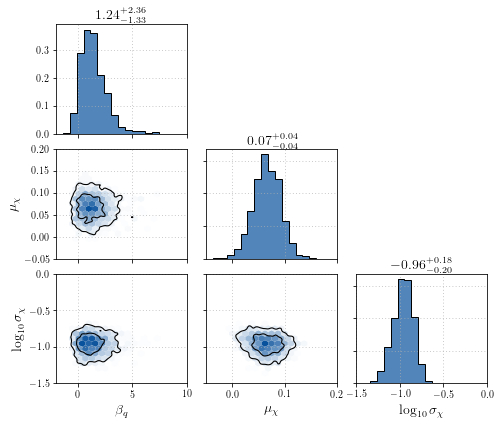

In [34]:
toPlot = {
    'beta':{'data':samps_no_evol[:,3],'plot_bounds':(-2,10),'label':r'$\beta_q$'},
    'mu0':{'data':samps_no_evol[:,5],'plot_bounds':(-0.05,0.2),'label':r'$\mu_\chi$'},
    'sig0':{'data':samps_no_evol[:,6],'plot_bounds':(-1.5,0.),'label':r'$\log_{10}\sigma_\chi$'}
    }

fig = plt.figure(figsize=(7,6))
plot_corner(fig,toPlot,'#08519c')
fig.subplots_adjust(wspace=0.15, hspace=0.14)
plt.savefig('./corner_noEvolution.pdf',bbox_inches='tight')
plt.show()

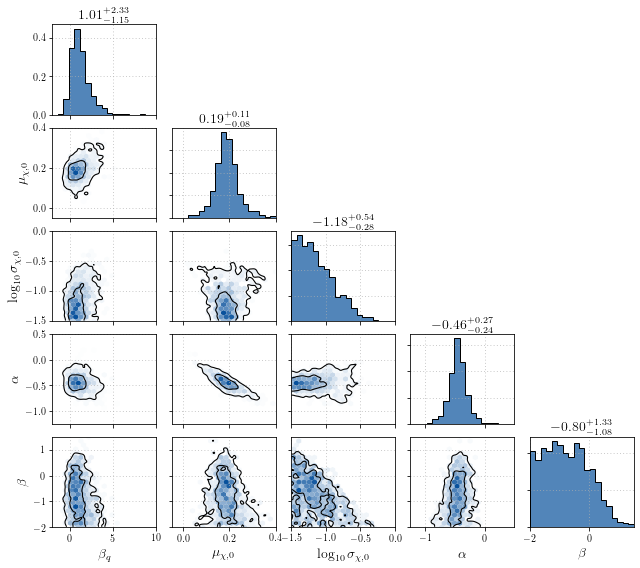

In [227]:
toPlot = {
    'beta':{'data':samps[:,3],'plot_bounds':(-2,10),'label':r'$\beta_q$'},
    'mu0':{'data':samps[:,5],'plot_bounds':(-0.05,0.4),'label':r'$\mu_{\chi,0}$'},
    'sig0':{'data':samps[:,6],'plot_bounds':(-1.5,0.),'label':r'$\log_{10}\sigma_{\chi,0}$'},
    'a':{'data':samps[:,7],'plot_bounds':(-1.25,0.5),'label':r'$\alpha$'},
    'b':{'data':samps[:,8],'plot_bounds':(-2,1.5),'label':r'$\beta$'}
    }

fig = plt.figure(figsize=(9,8))
plot_corner(fig,toPlot,'#08519c')
fig.subplots_adjust(wspace=0.15, hspace=0.14)
plt.savefig('./corner_yesEvolution.pdf',bbox_inches='tight')
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


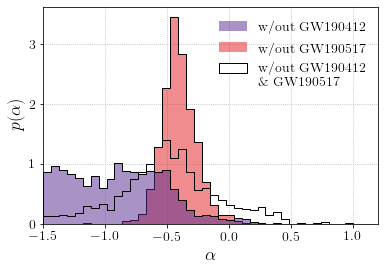

In [3]:
from matplotlib.patches import Rectangle

samps_no190517 = np.load('./../processed_emcee_samples_qDependence_no190517_r00.npy')
samps_no190412_no190517 = np.load('./../processed_emcee_samples_qDependence_no190412_no190517_r00.npy')
samps_w190814 = np.load('./../processed_emcee_samples_qDependence_w190814_betaMin-2.0.npy')

fig,ax = plt.subplots()
#facecolor='#08519c',
#ax.hist(samps[:,7],bins=np.linspace(-1.5,1,45),histtype='step',
#        color='black',alpha=0.8,label='Default',zorder=-1,lw=2

ax.hist(samps_no190412[:,7],bins=np.linspace(-1.5,1,40),histtype='stepfilled',
        color='#54278f',label='w/out GW190412',alpha=0.5,zorder=4,density=True)
ax.hist(samps_no190412[:,7],bins=np.linspace(-1.5,1,40),histtype='step',
        color='black',zorder=5,density=True)

ax.hist(samps_no190517[:,7],bins=np.linspace(-1.5,1,40),histtype='stepfilled',
        color='#e31a1c',label='w/out GW190517',alpha=0.5,zorder=2,density=True)
ax.hist(samps_no190517[:,7],bins=np.linspace(-1.5,1,40),histtype='step',
        color='black',zorder=3,density=True)

"""ax.hist(samps_w190814[:,7],bins=np.linspace(-1.5,1,40),histtype='stepfilled',
        color='#4daf4a',label='w/ GW190814',alpha=0.8,zorder=0,density=True)
ax.hist(samps_w190814[:,7],bins=np.linspace(-1.5,1,40),histtype='step',
        color='black',zorder=1,density=True)"""


ax.hist(samps_no190412_no190517[:,7],bins=np.linspace(-1.5,1,40),histtype='step',
        color='black',density=True,zorder=10)

leg2 = plt.legend([Rectangle((0,0),1,1,facecolor='white',edgecolor='black')],['w/out GW190412 \n \& GW190517'],
                  fontsize=14,frameon=False,loc=(0.51,0.63))
leg2.get_texts()[0].set_position((0,-7.5))

leg = ax.legend(loc='upper right',fontsize=14,frameon=False)
plt.gca().add_artist(leg2)

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$\alpha$',fontsize=18)
ax.set_ylabel(r'$p(\alpha)$',fontsize=18)
ax.set_xlim(-1.5,1.2)

plt.savefig('./alpha_posterior_outInTests.pdf',bbox_inches='tight')

plt.show()

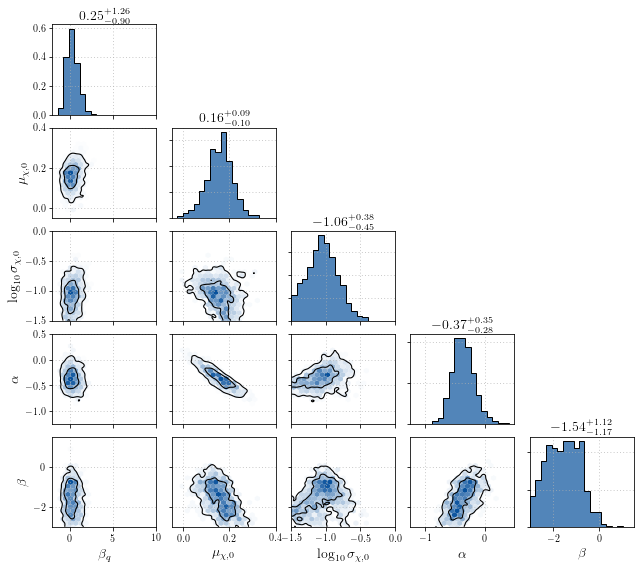

In [16]:
toPlot = {
    'beta':{'data':samps_w190814[:,3],'plot_bounds':(-2,10),'label':r'$\beta_q$'},
    'mu0':{'data':samps_w190814[:,5],'plot_bounds':(-0.05,0.4),'label':r'$\mu_{\chi,0}$'},
    'sig0':{'data':samps_w190814[:,6],'plot_bounds':(-1.5,0.),'label':r'$\log_{10}\sigma_{\chi,0}$'},
    'a':{'data':samps_w190814[:,7],'plot_bounds':(-1.25,0.5),'label':r'$\alpha$'},
    'b':{'data':samps_w190814[:,8],'plot_bounds':(-3,1.5),'label':r'$\beta$'}
    }

fig = plt.figure(figsize=(9,8))
plot_corner(fig,toPlot,'#08519c')
fig.subplots_adjust(wspace=0.15, hspace=0.14)
plt.savefig('./corner_yesEvolution_w190814.pdf',bbox_inches='tight')
plt.show()

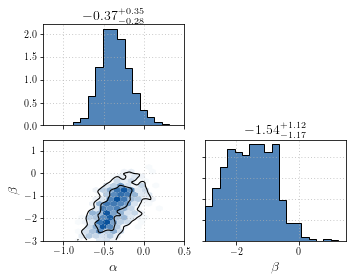

In [18]:
toPlot = {
    'a':{'data':samps_w190814[:,7],'plot_bounds':(-1.25,0.5),'label':r'$\alpha$'},
    'b':{'data':samps_w190814[:,8],'plot_bounds':(-3,1.5),'label':r'$\beta$'}
    }

fig = plt.figure(figsize=(5,4))
plot_corner(fig,toPlot,'#08519c')
fig.subplots_adjust(wspace=0.15, hspace=0.14)
plt.savefig('./corner_yesEvolution_w190814_small.pdf',bbox_inches='tight')
plt.show()

In [435]:
print(1-samps_no190517[:,7][samps_no190517[:,7]>0].size/samps_no190517[:,7].size)
print(1-samps_no190412[:,7][samps_no190412[:,7]>0].size/samps_no190412[:,7].size)
print(1-samps_no190412_no190517[:,7][samps_no190412_no190517[:,7]>0].size/samps_no190412_no190517[:,7].size)

0.9876644736842105
0.9809523809523809
0.8841911764705882


In [20]:
print(1-samps_w190814[:,7][samps_w190814[:,7]>0].size/samps_w190814[:,7].size)
print(1-samps_w190814[:,8][samps_w190814[:,8]>0].size/samps_w190814[:,8].size)

0.9605263157894737
0.9876644736842105


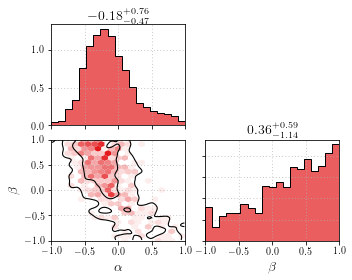

In [39]:
injection_samps = np.load('./../../injections/processed_emcee_samples_injection_qDependence_evol_r00.npy')[()]
toPlot = {
    'a':{'data':injection_samps[:,7],'plot_bounds':(-1.,1),'label':r'$\alpha$'},
    'b':{'data':injection_samps[:,8],'plot_bounds':(-1,1),'label':r'$\beta$'}
    }

fig = plt.figure(figsize=(5,4))
plot_corner(fig,toPlot,'#e31a1c',kernel=3)
fig.subplots_adjust(wspace=0.15, hspace=0.14)
plt.savefig('./corner_injection_small.pdf',bbox_inches='tight')
plt.show()